In [12]:
import numpy as np
import math
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## 問題1 チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [15]:
class SimpleConv1d():
    """畳み込みクラス"""
    def forward(self, x, w, b):
        """順伝播"""
        # x : 入力配列
        # w : 重み
        # b : バイアス
        a = np.empty((2, 3))
        a[0] = x[0:-1]*w # x[indexes0]は([1, 2, 3])である
        a[1] = x[1:]*w # x[indexes1]は([2, 3, 4])である
        a = a.sum(axis=1)
        return a + b
    
    def backward(self, x, w, da):
        """逆伝播"""
        # x : 入力配列
        # w : 重み
        # da : 逆伝播の値
        
        # ---勾配---
        # バイアスの分母
        db = np.sum(da)

        # 重みの分母
        dw = np.zeros(len(w))
        for i in range(len(w)):
            dw[i] = da @ x[i:i+len(da)]
        
        # 逆畳込み計算用配列
        new_w = np.insert(w[::-1], [0, 3], [0])

        # 逆伝播した値
        dx = np.zeros(len(new_w)-1)
        for i in range(len(new_w)-1):
            dx[i] = new_w[i:i+len(da)] @ da

        return db, dw, dx[::-1]

slc2 = SimpleConv1d()
da = slc2.forward(x, w, b)

print(f'forward : {slc2.forward(x, w, b)}')
# print(f'backward : {slc2.backward(x, w, da)}')
delta_a = np.array([10, 20])
print(f'backward : {slc2.backward(x, w, delta_a)}')

forward : [35. 50.]
backward : (30, array([ 50.,  80., 110.]), array([ 30., 110., 170., 140.]))


## 問題2 1次元畳み込み後の出力サイズの計算

In [32]:
n_in = 2 #入力する特徴量の数 [:, 2]ってこと
p = 2#パディングの数
f = (3, 3)#フィルタのサイズタプルのどちらかの数字 (x, y)それぞれの出力に合わせて選択
s = 3#ストライド

def output_size_calculation(n_in, p, f, s):
    """出力サイズを計算 ゼロつく212p参照"""
    n_out = int((n_in + (2 * p) - f) / s + 1)
    #fにint型を渡すなら上の[1]を削除する
    return n_out
print(output_size_calculation(n_in, p, f[1], s))

2


## 問題3 小さな配列での1次元畳み込み層の実験

### 問題1で作ったクラスを実装してみる

In [16]:
# テストデータ
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
da = np.array([10, 20])

# クラスの確認
slc = SimpleConv1d()
print(slc.forward(x, w, b))#[35 50]
print(slc.backward(x, w, da)[0])#(30, )
print(slc.backward(x, w, da)[1])#[50, 80, 110]
print(slc.backward(x, w, da)[2])#[30, 110, 170, 140]

# backwardのreturn dx[::-1]をもう少し綺麗にかけないか

[35. 50.]
30
[ 50.  80. 110.]
[ 30. 110. 170. 140.]


In [19]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)
print(a+b)

[35. 50.]


In [20]:
print(f'forward : {slc2.forward(x, w, b)}')
# print(f'backward : {slc2.backward(x, w, da)}')
delta_a = np.array([10, 20])
print(f'backward : {slc2.backward(x, w, delta_a)}')

forward : [35. 50.]
backward : (30, array([ 50.,  80., 110.]), array([ 30., 110., 170., 140.]))


## 問題4 チャンネル数を限定しない1次元畳み込み層クラスの作成

In [17]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [18]:
class ChannelFreeConv1d():
    """畳み込みクラス"""
    def forward(self, x, w, b):
        """順伝播"""
        # x : 入力配列
        # w : 重み
        # b : バイアス
        a = np.empty((2, 3))
        a[0] = x[0:-1]*w # x[indexes0]は([1, 2, 3])である
        a[1] = x[1:]*w # x[indexes1]は([2, 3, 4])である
        a = a.sum(axis=1)
        return a + b
    
    def backward(self, x, w, da):
        """逆伝播"""
        # x : 入力配列
        # w : 重み
        # da : 逆伝播の値
        
        # ---勾配---
        # バイアスの分母
        db = np.sum(da)

        # 重みの分母
        dw = np.zeros(len(w))
        for i in range(len(w)):
            dw[i] = da @ x[i:i+len(da)]
        
        # 逆畳込み計算用配列
        new_w = np.insert(w[::-1], [0, 3], [0])

        # 逆伝播した値
        dx = np.zeros(len(new_w)-1)
        for i in range(len(new_w)-1):
            dx[i] = new_w[i:i+len(da)] @ da

        return db, dw, dx[::-1]

cfc = ChannelFreeConv1d()

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [48]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データに
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 訓練データと評価データに
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

## 問題８

In [58]:
def output_size_calculation(n_in, F, P=0, S=1):
    """出力サイズ計算
    n_in : 入力サイズ
    F : フィルターサイズ
    P : パッディング数
    S : ストライド数
    """
    # 出力サイズの計算
    n_out = int((n_in + 2*P - F) / S + 1)
    
    return n_out
print(output_size_calculation(n_in=2, F=3, P=2, S=3))

class Sigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ReLU:
    
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class SGD:

    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
        
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B
    
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB

class Conv1d_Arbitrary_Strides:
    """畳み込みクラス"""
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        """コンストラクタ
        b_size : フィルターサイズ
        initializer : 初期化クラス
        optimizer : 最適化手法クラス
        n_in_channels : 入力チャンネル数
        n_out_channels : 出力チャンネル数
        pa : パディング数
        stride : ストライド数
        """
        self.b_size = b_size
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        # 重みの初期化
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        # バイアスの初期化
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        """順伝播
        X : 入力配列
        """
        # バッチ数
        self.n_samples = X.shape[0]
        # 入力配列の特徴量数
        self.n_in = X.shape[-1]
        # 出力サイズ
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        # 計算のためにX変形
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        # 0埋め実施
        self.X = np.pad(X, ((0,0), (0,0), ((self.b_size-1), 0)))
        # 出力配列（A）の計算のためゼロ配列X1を用意する
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.b_size, self.n_in+(self.b_size-1)))
        # 重みの長さでループ
        for i in range(self.b_size):
            # ずらしながら上書き
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        # 重みとバイアスを考慮して計算
        A = np.sum(self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        return A
    
    def backward(self, dA):
        """逆伝播
        dA : 逆伝播してきた配列
        """
        # 重みの勾配
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride], axis=(0, -1))
        # バイアスの勾配
        self.dB = np.sum(dA, axis=(0, -1))
        # 逆伝播の値計算のためにdAを変形
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.b_size-1))))
        # 出力配列（dX）の計算のためゼロ配列dA1を用意する
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.b_size, self.dA.shape[-1]))
        # 重みの長さでループ
        for i in range(self.b_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        # 重みとバイアスの更新
        self.optimizer.update(self)
        return dX
class ScratchCNNClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, verbose=True, Activater=Tanh, Optimizer=AdaGrad):
        """コンストラクタ
        Parameters
        -----------
        num_epoch : 学習回数
        lr : 学習率
        batch_size : バッチサイズ
        n_features : 特徴量数
        n_nodes1 : 1層目のノード数
        n_nodes2 : 2層目のノード数
        n_output : 出力層の数
        verbose : 仮定出力するか否か
        Activater : 活性化関数
        Optimizer : 最適化手法
        """
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose  
        self.batch_size = batch_size 
        self.n_features = n_features 
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output 
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """        
        # レイヤー初期化
        self.Conv1d_Arbitrary_Strides = Conv1d_Arbitrary_Strides(b_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=3, stride=2)
        self.Conv1d_Arbitrary_Strides.n_out = output_size_calculation(X.shape[-1], self.Conv1d_Arbitrary_Strides.b_size, self.Conv1d_Arbitrary_Strides.pa, self.Conv1d_Arbitrary_Strides.stride)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.Conv1d_Arbitrary_Strides.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()
        
        # loss配列定義と初期値格納（loss:ミニバッチごとの損失格納  loss_epoch:ミニバッチ学習終了後の全体損失）
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        
        # 学習回数分ループ
        for _ in range(self.num_epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            # イテレータ呼び出し
            for mini_X, mini_y in get_mini_batch:
                # 順伝播
                self.forward_propagation(mini_X)
                # 逆伝播
                self.back_propagation(mini_X, mini_y)
                # 損失記録
                self.loss.append(self.activation3.loss)
            # 損失記録
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
    
    def predict(self, X):
        """予測値出力
        Parameters
        ----------
        X : 説明変数
        """
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        """順伝播
        Parameters
        ----------
        X : 訓練データの説明変数
        """
        A1 = self.Conv1d_Arbitrary_Strides.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        """逆伝播
        Parameters
        ----------
        X : 訓練データの説明変数
        y_true : 正解データ
        """
        dA3 = self.activation3.backward(y_true) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d_Arbitrary_Strides.backward(dA1) 

# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データに
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 訓練データと評価データに
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
cnn = ScratchCNNClassifier(num_epoch=20, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=400, n_output=10, verbose=True, Activater=Tanh, Optimizer=SGD)
cnn.fit(X_train_[:1000], y_train_[:1000],X_test[:500],y_test[:500])

2


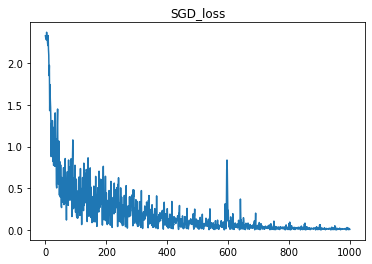

In [66]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

plt.title('SGD_loss')
plt.plot(cnn.loss, label='loss')
plt.show()